# Imports and Setup

In [ ]:
pip install pyspark

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('EDA_Project').getOrCreate()
spark

In [2]:
from pyspark.sql.functions import desc , sum , upper , when , col , count, avg

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Loading dataset

In [5]:
df = spark.read.csv('Forbes_Richest_Athletes.csv', header=True, inferSchema=True)

In [6]:
df.show(5, truncate=False)

+----+-----------------+-----------+------------+------------------+-----------+----+--------------------+
|S.NO|Name             |Nationality|Current Rank|Previous Year Rank|Sport      |Year|earnings ($ million)|
+----+-----------------+-----------+------------+------------------+-----------+----+--------------------+
|1   |Mike Tyson       |USA        |1           |null              |boxing     |1990|28.6                |
|2   |Buster Douglas   |USA        |2           |null              |boxing     |1990|26.0                |
|3   |Sugar Ray Leonard|USA        |3           |null              |boxing     |1990|13.0                |
|4   |Ayrton Senna     |Brazil     |4           |null              |auto racing|1990|10.0                |
|5   |Alain Prost      |France     |5           |null              |auto racing|1990|9.0                 |
+----+-----------------+-----------+------------+------------------+-----------+----+--------------------+
only showing top 5 rows



# Data Cleaning

In [7]:
df.select('Sport').distinct().show(truncate=False)

+----------------------------+
|Sport                       |
+----------------------------+
|Tennis                      |
|Boxing                      |
|Ice Hockey                  |
|Golf                        |
|Basketball                  |
|Auto Racing (Nascar)        |
|cycling                     |
|basketball                  |
|Auto Racing                 |
|auto racing                 |
|motorcycle gp               |
|golf                        |
|MMA                         |
|Auto racing                 |
|soccer                      |
|American Football / Baseball|
|baseball                    |
|F1 Motorsports              |
|Baseball                    |
|NBA                         |
+----------------------------+
only showing top 20 rows



I observe multiple mistakes within the distinct categories of sports which are as follows:
- Upper and lower cases are both considered different for the same sport such as - basketball/Basketball, baseball/Baseball, so every sport should be made the same case.

- NBA and Basketball should be made the same category - that is basketball.

- Auto racing (Nascar) and Nascar are also consider different, they also need to be merged

In [8]:
# Making all sports upper case
df = df.withColumn('Sport', upper(df.Sport))

# Merging NBA and basketball to BASKETBALL
df = df.withColumn('Sport', when(df.Sport=='NBA', 'BASKETBALL').otherwise(df.Sport))

# Merging auto racing nascar and nascar into one
df = df.withColumn('Sport', when(df.Sport=='AUTO RACING (NASCAR)', 'NASCAR').otherwise(df.Sport))

df.select('Sport').distinct().show(truncate=False)

+----------------------------+
|Sport                       |
+----------------------------+
|AUTO RACING                 |
|GOLF                        |
|BASKETBALL                  |
|AMERICAN FOOTBALL / BASEBALL|
|MOTORCYCLE GP               |
|TENNIS                      |
|HOCKEY                      |
|CYCLING                     |
|F1 RACING                   |
|MMA                         |
|ICE HOCKEY                  |
|BOXING                      |
|SOCCER                      |
|NFL                         |
|F1 MOTORSPORTS              |
|BASEBALL                    |
|AMERICAN FOOTBALL           |
|NASCAR                      |
+----------------------------+



In [9]:
df.where(df.Sport=='AMERICAN FOOTBALL / BASEBALL').show(truncate=False)

+----+-------------+-----------+------------+------------------+----------------------------+----+--------------------+
|S.NO|Name         |Nationality|Current Rank|Previous Year Rank|Sport                       |Year|earnings ($ million)|
+----+-------------+-----------+------------+------------------+----------------------------+----+--------------------+
|53  |Deion Sanders|USA        |3           |38                |AMERICAN FOOTBALL / BASEBALL|1995|22.5                |
+----+-------------+-----------+------------+------------------+----------------------------+----+--------------------+



Another observation made is that Deion Sanders is an athlete that played both professional american football as well as baseball. A fun fact - He is the only person to have played in both a Super Bowl and a World Series.

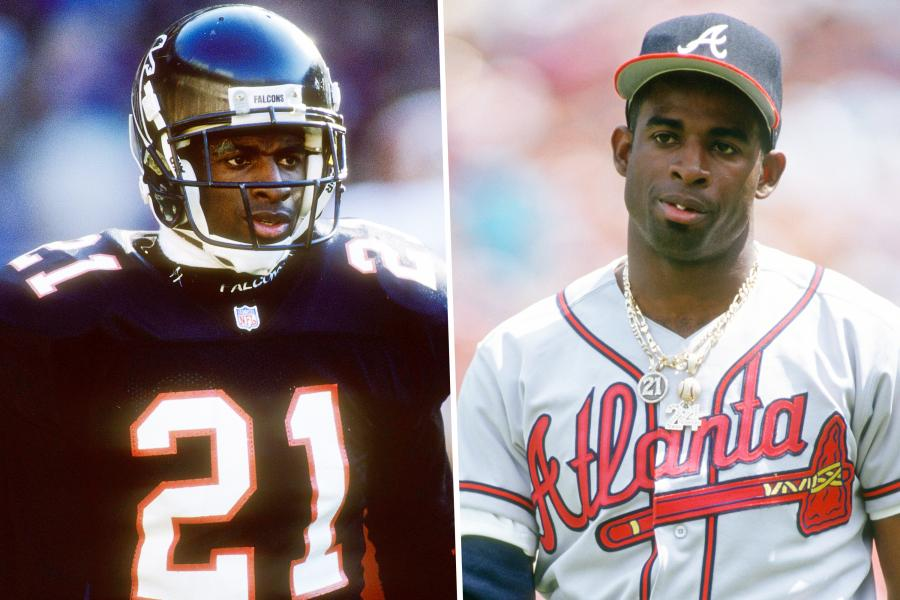

# EDA

In [10]:
# Dataframe columns and data types
df.printSchema()

root
 |-- S.NO: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Current Rank: integer (nullable = true)
 |-- Previous Year Rank: string (nullable = true)
 |-- Sport: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- earnings ($ million): double (nullable = true)



In [11]:
print("Total entries (rows) in the dataset = ", df.count())
print("Total number of columns in the dataset = ", len(df.columns))

Total entries (rows) in the dataset =  301
Total number of columns in the dataset =  8


In [12]:
# Top 10 paid athletes
df.orderBy(col('earnings ($ million)').desc()).limit(10).show(truncate=False)

+----+-----------------+-----------+------------+------------------+------+----+--------------------+
|S.NO|Name             |Nationality|Current Rank|Previous Year Rank|Sport |Year|earnings ($ million)|
+----+-----------------+-----------+------------+------------------+------+----+--------------------+
|242 |Floyd Mayweather |USA        |1           |1                 |BOXING|2015|300.0               |
|272 |Floyd Mayweather |USA        |1           |>100              |BOXING|2018|285.0               |
|243 |Manny Pacquiao   |Philippines|2           |11                |BOXING|2015|160.0               |
|282 |Lionel Messi     |Argentina  |1           |2                 |SOCCER|2019|127.0               |
|172 |Tiger Woods      |USA        |1           |1                 |GOLF  |2008|115.0               |
|273 |Lionel Messi     |Argentina  |2           |3                 |SOCCER|2018|111.0               |
|182 |Tiger Woods      |USA        |1           |1                 |GOLF  |2009|11

From the above table, we can observe that Floyd Mayweather, Manny Pacquiao, Lionel Messi and Tiger Woods are one of the highest paid athletes of all time.
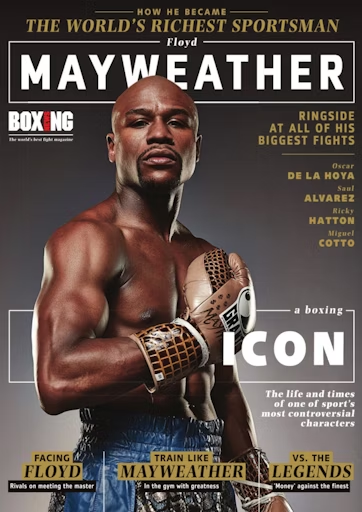

In [13]:
# Highest paid sports
top_paid_sports = df.groupBy('Sport').agg(sum('earnings ($ million)').alias('Total Earnings')).orderBy(desc('Total Earnings')).toPandas()
top_paid_sports

Sport  Total Earnings
0                     BASKETBALL          3433.3
1                         BOXING          2298.8
2                         SOCCER          2223.5
3                           GOLF          2136.5
4                         TENNIS          1017.3
5              AMERICAN FOOTBALL           901.2
6                      F1 RACING           397.0
7                    AUTO RACING           386.3
8                 F1 MOTORSPORTS           248.0
9                       BASEBALL           146.1
10                 MOTORCYCLE GP           128.0
11                        NASCAR           121.7
12                           MMA            99.0
13                    ICE HOCKEY            57.8
14                           NFL            37.5
15                       CYCLING            28.0
16  AMERICAN FOOTBALL / BASEBALL            22.5
17                        HOCKEY            17.9

From the above table we can observe that basketball is by far the highest paid sports amongst the most highest paid athletes, followed by boxing and then soccer.

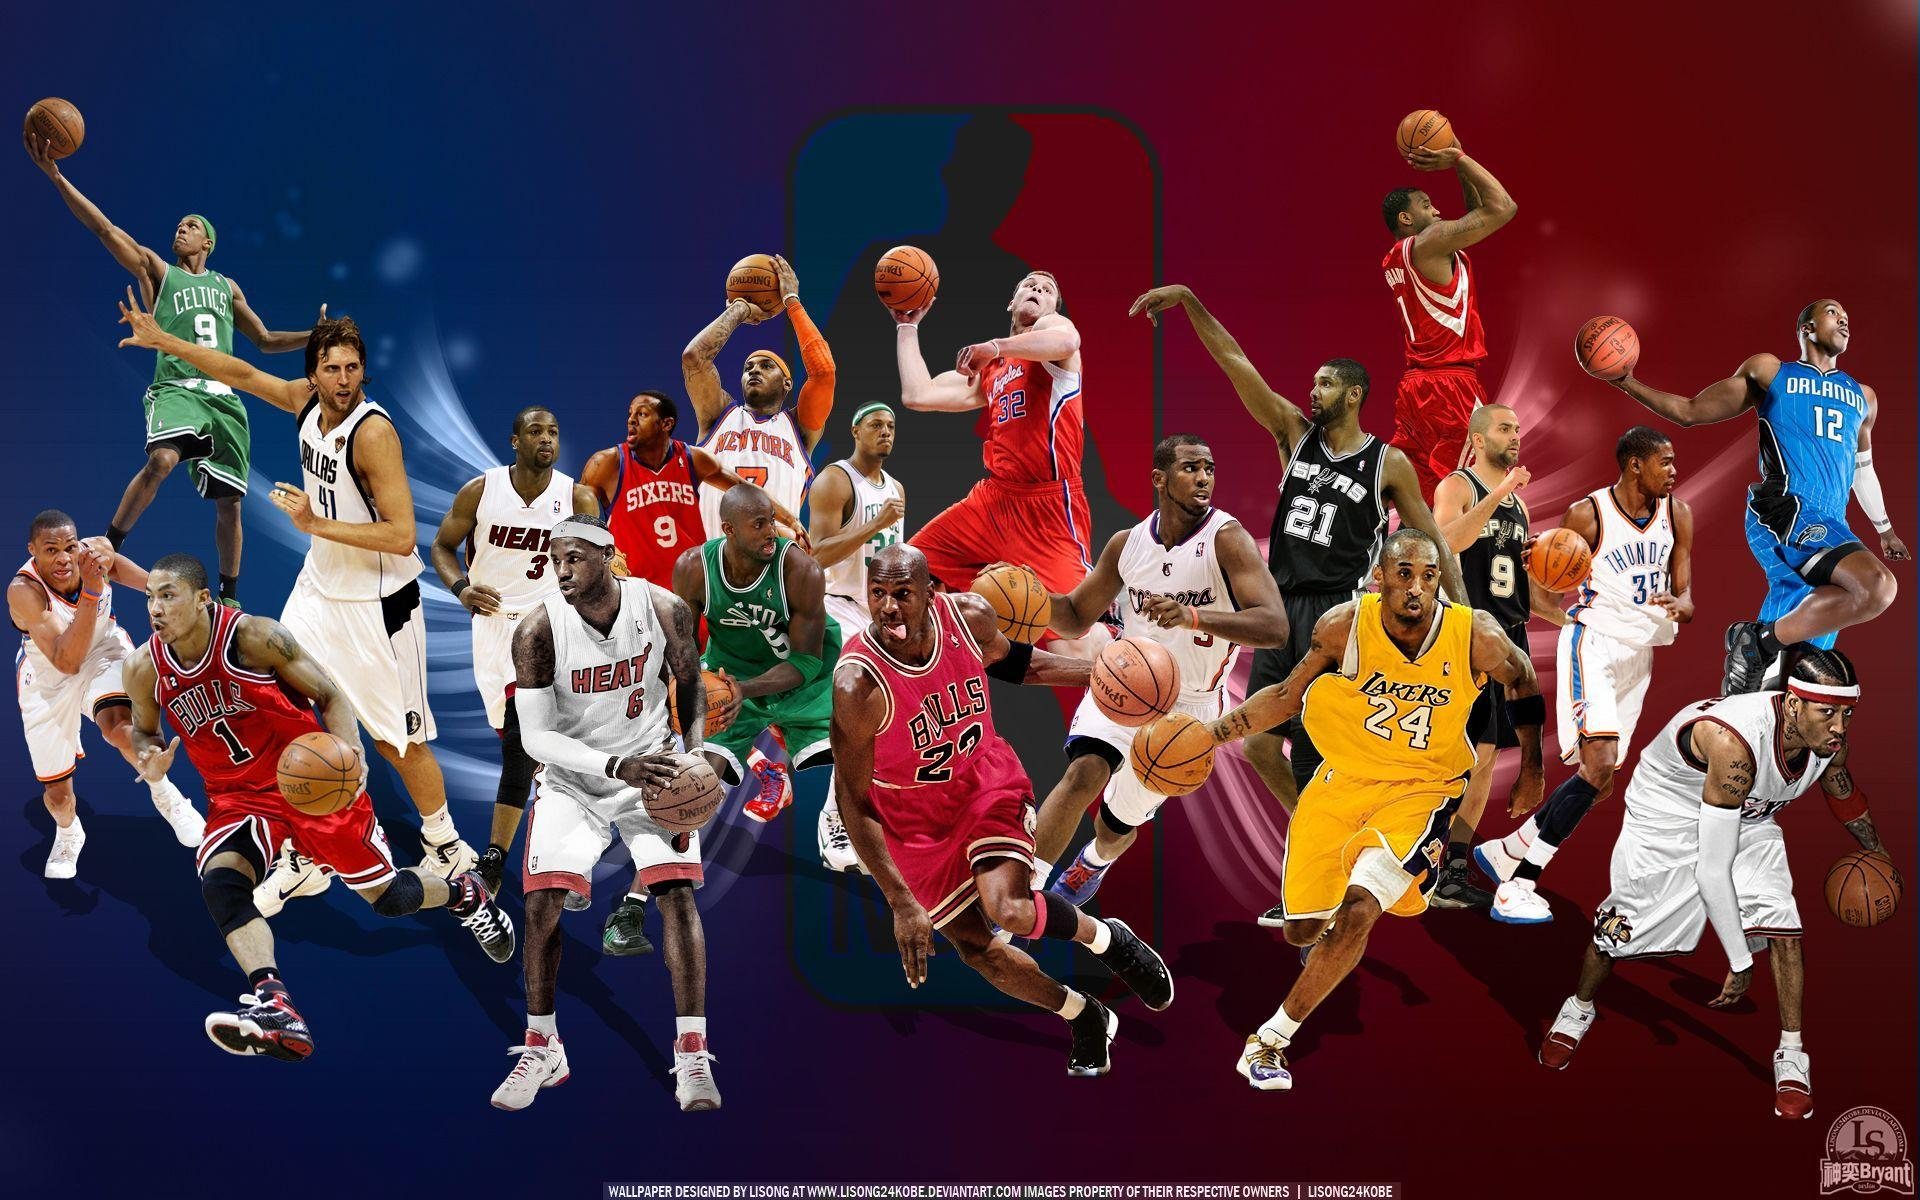

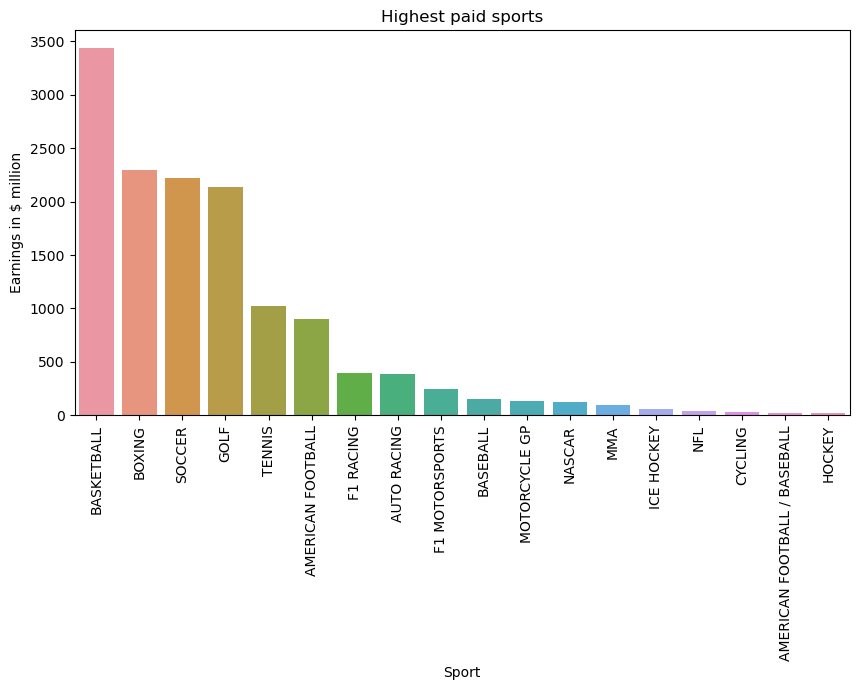

In [14]:
# Bar plot top paid sports
plt.figure(figsize=(10,5))
sns.barplot(x=top_paid_sports.Sport, y=top_paid_sports['Total Earnings'])
plt.xlabel('Sport')
plt.xticks(rotation=90)
plt.ylabel("Earnings in $ million")
plt.title('Highest paid sports')
plt.show()

In [15]:
# Next is to find out number of athletes in each sport
athletes_per_sport = df.groupBy('Sport').agg(count('Name').alias('Number of Athletes')).orderBy(desc('Number of Athletes')).toPandas()
athletes_per_sport

Sport  Number of Athletes
0                     BASKETBALL                  82
1                         BOXING                  46
2                           GOLF                  44
3                         SOCCER                  33
4                         TENNIS                  23
5                    AUTO RACING                  18
6              AMERICAN FOOTBALL                  17
7                      F1 RACING                   8
8                       BASEBALL                   6
9                 F1 MOTORSPORTS                   5
10                        NASCAR                   5
11                 MOTORCYCLE GP                   4
12                    ICE HOCKEY                   3
13                           NFL                   3
14  AMERICAN FOOTBALL / BASEBALL                   1
15                        HOCKEY                   1
16                       CYCLING                   1
17                           MMA                   1

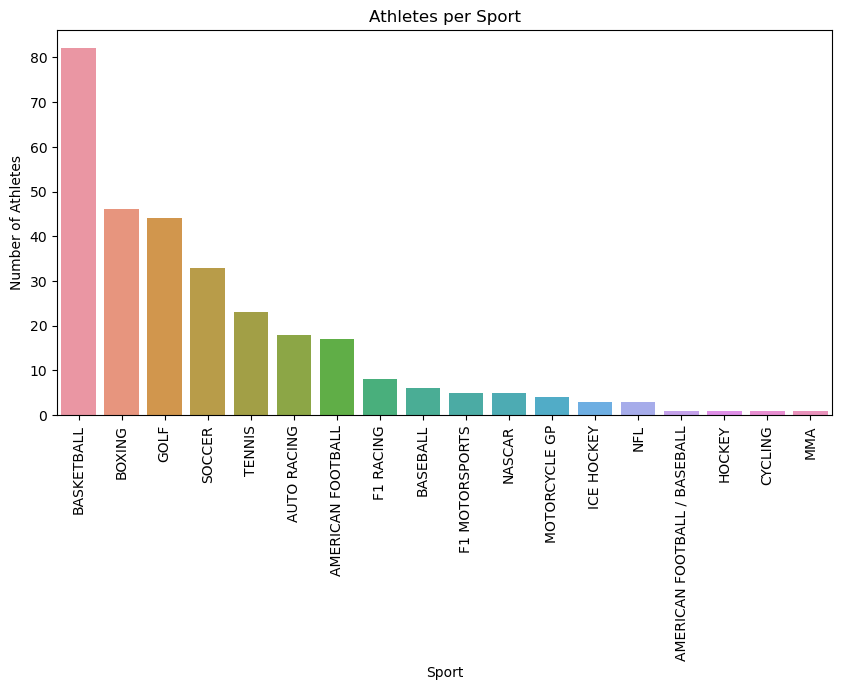

In [16]:
# Bar plot number of athletes per sport
plt.figure(figsize=(10,5))
sns.barplot(x=athletes_per_sport.Sport, y=athletes_per_sport['Number of Athletes'])
plt.xlabel('Sport')
plt.xticks(rotation=90)
plt.ylabel("Number of Athletes")
plt.title('Athletes per Sport')
plt.show()

In [21]:
# Next step is to find out average amount paid per sport
# calculation will be done by total earnings per sport divided by number of athletes in that sport

average_sport_salary = df.groupBy('Sport').agg(count('Name').alias('Total Athletes'), avg('earnings ($ million)').alias('Average Salary')).orderBy(desc('Average Salary')).toPandas()
average_sport_salary

Sport  Total Athletes  Average Salary
0                            MMA               1       99.000000
1                         SOCCER              33       67.378788
2              AMERICAN FOOTBALL              17       53.011765
3                         BOXING              46       49.973913
4                      F1 RACING               8       49.625000
5                 F1 MOTORSPORTS               5       49.600000
6                           GOLF              44       48.556818
7                         TENNIS              23       44.230435
8                     BASKETBALL              82       41.869512
9                  MOTORCYCLE GP               4       32.000000
10                       CYCLING               1       28.000000
11                      BASEBALL               6       24.350000
12                        NASCAR               5       24.340000
13  AMERICAN FOOTBALL / BASEBALL               1       22.500000
14                   AUTO RACING              18       21.461111
15                    ICE HOCKEY               3       19.266667
16                        HOCKEY               1       17.900000
17                           NFL               3       12.500000

In [28]:
# Average salary across sports with atleast 5 or more records
average_sport_salary[average_sport_salary['Total Athletes'] >= 5]

Sport  Total Athletes  Average Salary
1              SOCCER              33       67.378788
2   AMERICAN FOOTBALL              17       53.011765
3              BOXING              46       49.973913
4           F1 RACING               8       49.625000
5      F1 MOTORSPORTS               5       49.600000
6                GOLF              44       48.556818
7              TENNIS              23       44.230435
8          BASKETBALL              82       41.869512
11           BASEBALL               6       24.350000
12             NASCAR               5       24.340000
14        AUTO RACING              18       21.461111

In [29]:
# Number of athletes across each country
country_athletes = df.groupBy('Nationality').agg(count('Name').alias('Number of Athletes')).orderBy(desc('Number of Athletes')).toPandas()
country_athletes

Nationality  Number of Athletes
0                USA                 206
1            Germany                  13
2                 UK                  13
3        Switzerland                  12
4           Portugal                  10
5          Argentina                   9
6             Brazil                   9
7             Canada                   6
8              Italy                   4
9        Philippines                   3
10            France                   3
11           Finland                   3
12            Russia                   1
13          Filipino                   1
14             Spain                   1
15         Dominican                   1
16           Ireland                   1
17            Mexico                   1
18         Australia                   1
19           Austria                   1
20            Serbia                   1
21  Northern Ireland                   1

As we can see, amongst the highest paid athletes - USA by far contributes the most

# Player Graph

In [36]:
# next we will look at salary progression for my favorite basketball player - Stephen Curry

In [50]:
steph_curry_df = df.where(df.Name == 'Stephen Curry').toPandas()
steph_curry_df

S.NO           Name Nationality  Current Rank Previous Year Rank  \
0   269  Stephen Curry         USA             8               None   
1   279  Stephen Curry         USA             8                  8   
2   290  Stephen Curry         USA             9                  8   
3   297  Stephen Curry         USA             6                  9   

        Sport  Year  earnings ($ million)  
0  BASKETBALL  2017                  47.3  
1  BASKETBALL  2018                  76.9  
2  BASKETBALL  2019                  79.8  
3  BASKETBALL  2020                  74.4

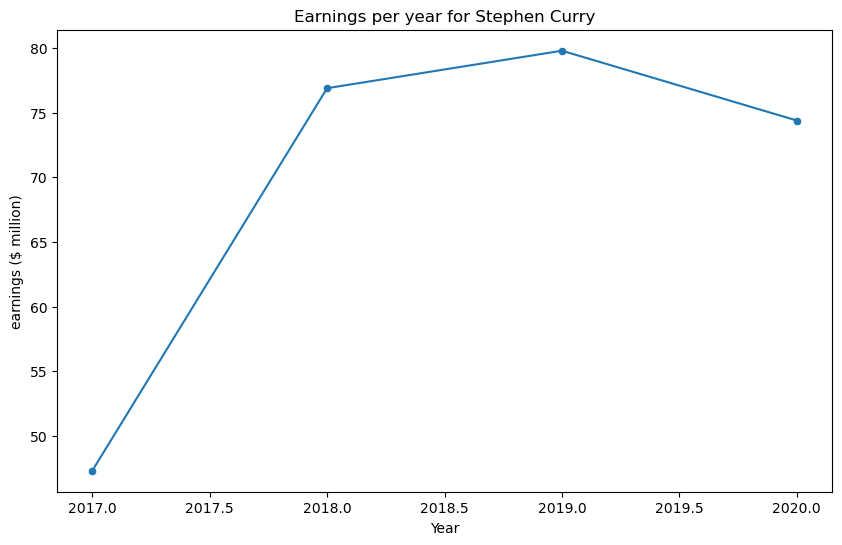

In [65]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=steph_curry_df.Year, y=steph_curry_df['earnings ($ million)'])
sns.lineplot(x=steph_curry_df.Year, y=steph_curry_df['earnings ($ million)'])
plt.xlabel('Year')
plt.ylabel('earnings ($ million)')
plt.title(f"Earnings per year for Stephen Curry")
plt.show()